In [1]:
import moxing as mox
 
mox.file.copy_parallel('obs://modelsarts-eric/flowers/', '/home/ma-user/work')

INFO:root:Using MoXing-v2.1.0.5d9c87c8-5d9c87c8
INFO:root:Using OBS-Python-SDK-3.20.9.1
INFO:root:Listing OBS: 1000
INFO:root:Listing OBS: 2000
INFO:root:Listing OBS: 3000
INFO:root:1000/3674
INFO:root:2000/3674
INFO:root:3000/3674


In [2]:
import mindspore as ms
import mindspore.dataset as ds
import mindspore.dataset.vision.c_transforms as CV
import mindspore.dataset.transforms.c_transforms as C


def creat_dataset(dir, img_size=[224, 224], batch_size=128):
    data = ds.ImageFolderDataset(dir,
                                 class_indexing={"daisy": 0,
                                                 "dandelion": 1,
                                                 "roses": 2,
                                                 "sunflowers": 3,
                                                 "tulips": 4})
    trans = CV.RandomCropDecodeResize(img_size, scale=(0.08, 1.0), ratio=(0.75, 1.33))
    ds_type = C.TypeCast(ms.float32)
    data = data.map(input_columns="image", operations=trans)
    data = data.map(input_columns="image", operations=CV.HWC2CHW())
    data = data.map(input_columns="image", operations=ds_type)
    data = data.shuffle(buffer_size=batch_size * 10)
    data = data.batch(batch_size, drop_remainder=True)
    data = data.map(input_columns="image", operations=CV.Rescale(1.0 / 255, 0))
    return data


In [3]:
import numpy as np
from mindspore import nn, context
from mindspore import Tensor
import mindspore as ms


class VggNet(nn.Cell):
    def __init__(self, net_name='vgg16', num_classes=5, keep_prob=0.1):
        super(VggNet, self).__init__()

        self.cfgs = {
            # 列表中的数字代表卷积层卷积的层数，M 代表 maxpool
            'vgg11': [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
            'vgg13': [64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
            'vgg16': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M'],
            'vgg19': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M', 512, 512, 512, 512,
                      'M'],
        }

        self.name = net_name
        self.num_classes = num_classes
        self.keep_prob = keep_prob

        self.classifier = nn.SequentialCell(
            nn.Dense(512 * 7 * 7, 4096),
            nn.ReLU(),
            nn.Dropout(keep_prob=self.keep_prob),
            nn.Dense(4096, 4096),
            nn.ReLU(),
            nn.Dropout(keep_prob=self.keep_prob),
            nn.Dense(4096, self.num_classes)
        )

        self.baseline = self.Baseline(cfg=self.cfgs[self.name])

    def Baseline(self, cfg: list):
        layers = []
        in_channels = 3
        for v in cfg:
            if v == "M":
                layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
            else:
                conv2d = nn.Conv2d(in_channels, v, kernel_size=3, pad_mode='same', padding=0, has_bias=True)
                layers += [conv2d, nn.BatchNorm2d(v) ,nn.ReLU()]
                in_channels = v
        return nn.SequentialCell(*layers)

    def construct(self, x):
        emb = self.baseline(x)
        emb = emb.reshape(emb.shape[0], 512 * 7 * 7)
        pre = self.classifier(emb)
        return pre



train

In [ ]:

import mindspore as ms
from mindspore import nn, context, Model, load_checkpoint, load_param_into_net
import mindspore.dataset.vision.c_transforms as CV
import mindspore.dataset.transforms.c_transforms as C
from mindspore.train.callback import LossMonitor, ModelCheckpoint, CheckpointConfig
from mindspore.common.initializer import initializer, Normal
import matplotlib.pyplot as plt
import matplotlib
import os
import numpy as np
from mindspore import load_checkpoint, load_param_into_net


num_epochs, lr = 100, 1e-5


data_train = creat_dataset("flower_photos/train")
data_test = creat_dataset("flower_photos/test")

net = VggNet()

# param_dict = load_checkpoint("/home/ma-user/work/checkpoint/checkpoint_net_1-13_23.ckpt")
param_dict = load_checkpoint("/home/ma-user/work/base.ckpt")
load_param_into_net(net, param_dict)


loss = nn.loss.SoftmaxCrossEntropyWithLogits(sparse=True, reduction='mean')
opt = nn.Adam(net.trainable_params(), lr)
loss_cb = LossMonitor(per_print_times=data_train.get_dataset_size())
# loss_cb = LossMonitor(per_print_times=1)

model = Model(net, loss, opt, metrics={'acc', 'loss'})

model_path = "./checkpoint/"
config_ck = CheckpointConfig(save_checkpoint_steps=data_train.get_dataset_size(), keep_checkpoint_max=5)
ckpoint_cb = ModelCheckpoint(prefix="checkpoint_net", directory=model_path, config=config_ck)

context.set_context(mode=context.GRAPH_MODE, device_target="GPU")
model.train(num_epochs, data_train, callbacks=[loss_cb, ckpoint_cb], dataset_sink_mode=False)

metrics = model.eval(data_test, dataset_sink_mode=False)
print('Metrics:', metrics)

epoch: 1 step: 23, loss is 0.5495755076408386
epoch: 2 step: 23, loss is 0.40164971351623535
epoch: 3 step: 23, loss is 0.47871163487434387
epoch: 4 step: 23, loss is 0.4063253700733185
epoch: 5 step: 23, loss is 0.5187987089157104
epoch: 6 step: 23, loss is 0.32131826877593994
epoch: 7 step: 23, loss is 0.1994253695011139
epoch: 8 step: 23, loss is 0.33639830350875854
epoch: 9 step: 23, loss is 0.30278968811035156


In [5]:
import moxing as mox
 
mox.file.copy_parallel('/home/ma-user/work/checkpoint/checkpoint_net-7_23.ckpt', 'obs://modelsarts-eric/flowers/base.ckpt')

predict

In [5]:
import mindspore as ms
from mindspore import nn, context, Model, load_checkpoint, load_param_into_net
import mindspore.dataset.vision.c_transforms as CV
import mindspore.dataset.transforms.c_transforms as C
from mindspore.train.callback import LossMonitor, ModelCheckpoint, CheckpointConfig
from mindspore.common.initializer import initializer, Normal
import matplotlib.pyplot as plt
import matplotlib
import os
import numpy as np
from mindspore import load_checkpoint, load_param_into_net

num_epochs, lr = 100, 1e-5

data_train = creat_dataset("flower_photos/train")
data_test = creat_dataset("flower_photos/test")

net = VggNet()

# param_dict = load_checkpoint("/home/ma-user/work/checkpoint/checkpoint_net_1-13_23.ckpt")
param_dict = load_checkpoint("/home/ma-user/work/base.ckpt")
load_param_into_net(net, param_dict)


loss = nn.loss.SoftmaxCrossEntropyWithLogits(sparse=True, reduction='mean')
opt = nn.Adam(net.trainable_params(), lr)
loss_cb = LossMonitor(per_print_times=data_train.get_dataset_size())
# loss_cb = LossMonitor(per_print_times=1)

model = Model(net, loss, opt, metrics={'acc', 'loss'})

context.set_context(mode=context.GRAPH_MODE, device_target="GPU")

metrics = model.eval(data_test, dataset_sink_mode=False)
print('Metrics:', metrics)

Metrics: {'acc': 0.7828125, 'loss': 0.8691848516464233}


可视化

the pic 3 roses-->tulips
the pic 5 tulips-->daisy
the pic 7 sunflowers-->dandelion
the pic 17 roses-->daisy
the pic 18 tulips-->roses
the pic 20 roses-->sunflowers
the pic 27 tulips-->daisy
the pic 28 tulips-->roses


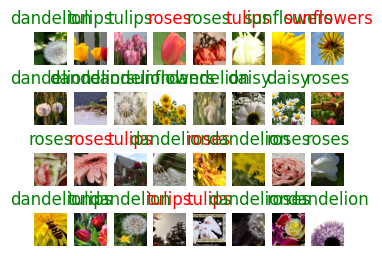

In [10]:
import numpy as np

classes = ["daisy","dandelion","roses","sunflowers","tulips"]


for data, label in data_test:
    pre = model.predict(data).asnumpy()
    predicted = np.argmax(pre, 1)
    # print(predicted)
    ground_trues = label.asnumpy()
    data = data.asnumpy()
    
    data = (data - data.min(axis=0)) / (data.max(axis=0) - data.min(axis=0))
    
    
    plt.figure(figsize=(12,12))
    for i in range(32):
        plt.subplot(4, 8, i + 1)
        if predicted[i] == ground_trues[i]:
            plt.title("{}".format(classes[predicted[i]]), color="green")
        else:
            plt.title("{}".format(classes[predicted[i]]), color="red")
            print("the pic " + str(i) + " " + classes[predicted[i]] + "-->" + classes[ground_trues[i]])
        img = np.transpose(data[i], (1, 2, 0))
        plt.imshow(img)
        plt.axis("off")
    plt.show()
    plt.pause(0.1)

    
    break